In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/duke/ECE 661/final project/code')

In [3]:
import os
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from Models import StudentSimpleNN, TeacherSimpleNN

## Test network

In [4]:
input_test = torch.randn([3, 28, 28])
StudentNetwork = StudentSimpleNN()
out = StudentNetwork(input_test)
print(out.size())

TeacherNetwork = TeacherSimpleNN()
out = TeacherNetwork(input_test)
print(out.size())

torch.Size([3, 10])
torch.Size([3, 10])


## Data Preprocess

In [5]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [6]:
MNISI_shape = (28, 28)
pad_size = 2
TRAIN_BATCH_SIZE = 128


transform_train = transforms.Compose([transforms.RandomCrop(MNISI_shape, pad_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5], [0.5])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.5], [0.5])])

train_MNIST = torchvision.datasets.MNIST(root='./', train=True, download=True, transform = transform_train)

test_MNIST = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform_test)

num_train = int(1.0 * len(train_MNIST) * 95 / 100)
num_val = len(train_MNIST) - num_train
train_MNIST, val_MNIST = torch.utils.data.random_split(train_MNIST, [num_train, num_val])

train_loader = DataLoader(
    train_MNIST, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_MNIST, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_MNIST, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model is deployed to", device)

StudentNet = StudentSimpleNN().to(device)
TeacherNet = TeacherSimpleNN().to(device)

The model is deployed to cuda:0


In [8]:
trained_teacher_model = TeacherSimpleNN()
checkpoint = torch.load("/content/drive/MyDrive/duke/ECE 661/final project/code/checkpoints/TeacherNet.pth")
trained_teacher_model.load_state_dict(checkpoint['state_dict'])
trained_teacher_model.to(device)
trained_teacher_model.eval()

TeacherSimpleNN(
  (linear1): Linear(in_features=784, out_features=1200, bias=True)
  (linear2): Linear(in_features=1200, out_features=1200, bias=True)
  (linear3): Linear(in_features=1200, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## FLOPS

In [18]:
StudentSimpleNN()

StudentSimpleNN(
  (linear1): Linear(in_features=784, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=10, bias=True)
  (linear3): Linear(in_features=400, out_features=10, bias=True)
)

In [20]:
2 * 784 * 400 + 2 * 400 * 10

635200

In [19]:
TeacherSimpleNN()

TeacherSimpleNN(
  (linear1): Linear(in_features=784, out_features=1200, bias=True)
  (linear2): Linear(in_features=1200, out_features=1200, bias=True)
  (linear3): Linear(in_features=1200, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [21]:
2 * 784 * 1200 + 2 * 1200 * 1200 + 2 * 1200 * 10

4785600

In [17]:
for name, module in TeacherNet.named_modules():
  input = module.linear1.weight
  #output = module.output
  # num_param = len(module.weight.reshape(-1))
  print("name: {}".format(input))

name: Parameter containing:
tensor([[ 0.0246,  0.0195, -0.0226,  ..., -0.0204,  0.0244,  0.0213],
        [ 0.0026,  0.0080,  0.0189,  ...,  0.0107, -0.0018,  0.0059],
        [ 0.0241,  0.0020, -0.0177,  ..., -0.0051,  0.0057, -0.0353],
        ...,
        [-0.0104, -0.0326, -0.0263,  ..., -0.0168, -0.0346,  0.0138],
        [ 0.0124,  0.0151, -0.0339,  ...,  0.0132, -0.0258,  0.0307],
        [-0.0224, -0.0032,  0.0108,  ...,  0.0158, -0.0346,  0.0207]],
       device='cuda:0', requires_grad=True)


AttributeError: ignored

## The function of train models

In [ ]:
LEARNING_RATE = 0.01
LEARNING_RATE_DECAY = 0.95

WEIGHT_DECAY = 1e-4

MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()

EPOCHS = 60

DECAY_EPOCHS = 10
DECAY = 1.0

CHECKPOINT_PATH = "/content/drive/MyDrive/duke/ECE 661/final project/code/checkpoints"

# for student model
T = 1
alpha = 0.7 # 0.7

In [ ]:
def train_model(model, mode, train_loader, save_name):

  print("Now T is {}".format(T))

  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

  best_val_acc = 0
  current_learning_rate = LEARNING_RATE

  softmax = torch.nn.Softmax(dim=1)

  print("==> Start training!")
  print("="*50)

  for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i !=0:
      current_learning_rate = current_learning_rate * LEARNING_RATE_DECAY
      for param_group in optimizer.param_groups:
        param_group['lr'] = current_learning_rate
      print("Current learning rate has decayed to {}".format(current_learning_rate))

    model.train()

    print("Epoch {}".format(i))

    total_examples = 0
    correct_examples = 0

    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      pred = model(inputs)
      if mode == "teacher" or mode == "studentOri":
        train_loss = criterion(pred, targets)
      else:
        if alpha > 0:
          with torch.no_grad():
            teacher_pred = trained_teacher_model(inputs)
        else:
          teacher_pred = 0
        train_loss = studentLoss(teacher_pred, pred, targets, T, alpha)

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      total_examples += inputs.shape[0]

      out = softmax(pred)
      out = torch.max(out, 1)

      correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: {}, training accuracy: {}".format(avg_loss, avg_acc))

    model.eval()

    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(val_loader):

        inputs, targets = inputs.to(device), targets.to(device)

        pred = model(inputs)
        val_loss = criterion(pred, targets)

        total_examples += inputs.shape[0]

        out = softmax(pred)
        out = torch.max(out, 1)

        correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Val loss: {}, val accuracy: {}".format(avg_loss, avg_acc))

    if avg_acc > best_val_acc:
      best_val_acc = avg_acc
      print("Saving ...")
      state = {'state_dict': model.state_dict(),
              'epoch': i,
              'lr': current_learning_rate}
      
      # if mode == "teacher":
      #   model_name = "TeacherNet.pth"
      # elif mode == "studentOri":
      #   model_name = "StudentNetOri.pth"
      # else:
      #   model_name = "T_" + str(T) + "_KDStudentNet.pth"
      
      torch.save(state, os.path.join(CHECKPOINT_PATH, save_name))

    print('')

  print("="*50)
  print("==> Finished Training! The best accuracy is {}".format(best_val_acc))


In [ ]:
def test_model(model_name, mode):
  if mode == "teacher":
    model = TeacherSimpleNN()
  else:
    model = StudentSimpleNN()

  checkpoint = torch.load(os.path.join(CHECKPOINT_PATH, model_name))
  model.load_state_dict(checkpoint['state_dict'])
  model.to(device)
  model.eval()

  total_examples = 0
  correct_examples = 0
  softmax = torch.nn.Softmax(dim=1)

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

      inputs, targets = inputs.to(device), targets.to(device)

      pred = model(inputs)

      total_examples += inputs.shape[0]

      out = softmax(pred)
      out = torch.max(out, 1)

      correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

  avg_acc = correct_examples / total_examples
  print("Total examples is {}, correct examples is {}; Test accuracy: {}".format(total_examples, correct_examples, avg_acc))


## Teacher Model

In [ ]:
# TeacherNet = TeacherSimpleNN().to(device)
# train_model(TeacherNet, "teacher")

In [ ]:
test_model("TeacherNet.pth", "teacher")

Total examples is 10000, correct examples is 9887; Test accuracy: 0.9887


## Student Model

In [ ]:
def studentLoss(teacher_pred, student_pred, targets, T, alpha):
  """
  Loss function for student network: Loss = alpha * (distillation loss with soft-target) + (1 - alpha) * (cross-entropy loss with true label)
	Return: loss
  """
  if alpha > 0:
    loss = F.kl_div(F.softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T**2) * alpha + F.cross_entropy(student_pred, targets) * (1 - alpha)
  else:
    loss = F.cross_entropy(student_pred, targets)
  
  return loss

In [ ]:
StudentNet = StudentSimpleNN().to(device)
train_model(StudentNet, "studentOri", train_loader, "studentOri_alpha01.pth")

Now T is 1
==> Start training!
Epoch 0
Training loss: 0.0008786359103396535, training accuracy: 0.7356491228070176
Val loss: 0.014092715457081795, val accuracy: 0.871
Saving ...

Epoch 1
Training loss: 0.0007547381683252752, training accuracy: 0.8956491228070176
Val loss: 0.011453873477876186, val accuracy: 0.9276666666666666
Saving ...

Epoch 2
Training loss: 0.0006024328758940101, training accuracy: 0.9301929824561403
Val loss: 0.008119028061628342, val accuracy: 0.93
Saving ...

Epoch 3
Training loss: 0.00015600444748997688, training accuracy: 0.9423684210526316
Val loss: 0.006668878719210625, val accuracy: 0.9416666666666667
Saving ...

Epoch 4
Training loss: 0.00025375670520588756, training accuracy: 0.9473684210526315
Val loss: 0.006049653049558401, val accuracy: 0.9486666666666667
Saving ...

Epoch 5
Training loss: 0.00018222567450720817, training accuracy: 0.9527543859649122
Val loss: 0.0032350486144423485, val accuracy: 0.9556666666666667
Saving ...

Epoch 6
Training loss: 0.0

In [ ]:
test_model("StudentNetOri.pth", "student")

Total examples is 10000, correct examples is 9857; Test accuracy: 0.9857


In [ ]:
StudentNet = StudentSimpleNN().to(device)
train_model(StudentNet, "KDStudent", train_loader, "studentKD_alpha01.pth")

Now T is 1
==> Start training!
Epoch 0
Training loss: 0.0007320089498534799, training accuracy: 0.7282456140350877
Val loss: 0.016094662249088287, val accuracy: 0.856
Saving ...

Epoch 1
Training loss: 0.0004601279797498137, training accuracy: 0.8919122807017544
Val loss: 0.00945367943495512, val accuracy: 0.923
Saving ...

Epoch 2
Training loss: 0.00014840307994745672, training accuracy: 0.9284035087719298
Val loss: 0.010069044306874275, val accuracy: 0.9413333333333334
Saving ...

Epoch 3
Training loss: 0.0005979017587378621, training accuracy: 0.9401929824561404
Val loss: 0.009637534618377686, val accuracy: 0.9463333333333334
Saving ...

Epoch 4
Training loss: 0.00011982600699411705, training accuracy: 0.9489122807017544
Val loss: 0.01147396769374609, val accuracy: 0.955
Saving ...

Epoch 5
Training loss: 0.0001865160302259028, training accuracy: 0.9527543859649122
Val loss: 0.012406110763549805, val accuracy: 0.9563333333333334
Saving ...

Epoch 6
Training loss: -5.174531906959601e

In [ ]:
test_model("KDStudentNet.pth", "KDStudent")

Total examples is 10000, correct examples is 9863; Test accuracy: 0.9863


In [ ]:
T_list = [20, 30, 40, 50, 60, 70, 80, 90, 100]  # 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9， 2, 3, 4, 5, 6, 7, 8, 9, 10
for T in T_list:
  StudentNet = StudentSimpleNN().to(device)
  model_name = "T_" + str(T) + "_KDStudentNet.pth"
  train_model(StudentNet, "KDStudent", train_loader, save_name = model_name)

Now T is 20
==> Start training!
Epoch 0
Training loss: -0.21100632846355438, training accuracy: 0.722561403508772
Val loss: 0.024117683991789818, val accuracy: 0.8286666666666667
Saving ...

Epoch 1
Training loss: -0.2115207463502884, training accuracy: 0.8778771929824561
Val loss: 0.018347488716244698, val accuracy: 0.9066666666666666
Saving ...

Epoch 2
Training loss: -0.21266768872737885, training accuracy: 0.905719298245614
Val loss: 0.015518459491431713, val accuracy: 0.8956666666666667

Epoch 3
Training loss: -0.21087253093719482, training accuracy: 0.9129122807017543
Val loss: 0.06547026336193085, val accuracy: 0.9213333333333333
Saving ...

Epoch 4
Training loss: -0.21364814043045044, training accuracy: 0.9204561403508772
Val loss: 0.007759190164506435, val accuracy: 0.93
Saving ...

Epoch 5
Training loss: -0.21441122889518738, training accuracy: 0.9274561403508772
Val loss: 0.012312270700931549, val accuracy: 0.9426666666666667
Saving ...

Epoch 6
Training loss: -0.21579352021

In [ ]:
T_list = [20, 30, 40, 50, 60, 70, 80, 90, 100] # T_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]  2, 3, 4, 5, 6, 7, 8, 9, 10
for t in T_list:
  print("Now T is", t)
  model_name = "T_" + str(t) + "_KDStudentNet.pth"
  test_model(model_name, "KDStudent")

Now T is 20
Total examples is 10000, correct examples is 9814; Test accuracy: 0.9814
Now T is 30
Total examples is 10000, correct examples is 9833; Test accuracy: 0.9833
Now T is 40
Total examples is 10000, correct examples is 9802; Test accuracy: 0.9802
Now T is 50
Total examples is 10000, correct examples is 9825; Test accuracy: 0.9825
Now T is 60
Total examples is 10000, correct examples is 9838; Test accuracy: 0.9838
Now T is 70
Total examples is 10000, correct examples is 9838; Test accuracy: 0.9838
Now T is 80
Total examples is 10000, correct examples is 9833; Test accuracy: 0.9833
Now T is 90
Total examples is 10000, correct examples is 9809; Test accuracy: 0.9809
Now T is 100
Total examples is 10000, correct examples is 9835; Test accuracy: 0.9835


In [ ]:
import matplotlib.pyplot as plt

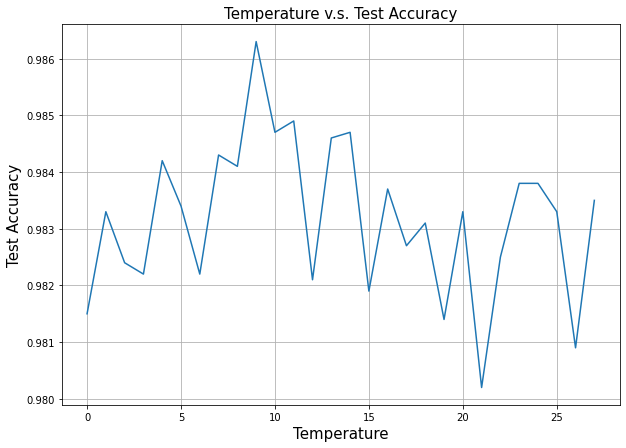

In [ ]:
T_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,2,3,4,5,6,7,8,9,10, 20, 30, 40,50,60,70,80,90,100]
test_acc = [0.9815, 0.9833, 0.9824, 0.9822, 0.9842, 0.9834, 0.9822, 0.9843, 0.9841, 
            0.9863, 0.9847, 0.9849, 0.9821, 0.9846, 0.9847, 0.9819, 0.9837, 0.9827, 0.9831,
            0.9814, 0.9833, 0.9802, 0.9825, 0.9838, 0.9838, 0.9833, 0.9809, 0.9835]
plt.figure(figsize=(10, 7))
plt.xlabel("Temperature", size=15)
plt.ylabel("Test Accuracy", size=15)
plt.title("Temperature v.s. Test Accuracy", size=15)
plt.grid()
plt.plot(test_acc)
plt.show()

## Randomly Omit One Digit

In [ ]:
def my_collate(batch):

  targets_list = []
  count = 0

  for item in batch:
    inputs, targets = item
    # print(targets)
    if targets != 3:
      count += 1
      if count == 1:
        inputs_tensor = inputs
      else:
        inputs_tensor = torch.cat((inputs_tensor, inputs), 0)
      targets_list.append(targets)

  targets_tensor = torch.tensor(np.array(targets_list))
  # print(targets_tensor)
  return (inputs_tensor, targets_tensor)

In [ ]:
student_train_loader = DataLoader(
    train_MNIST, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn = my_collate
)

In [ ]:
T = 1
StudentNet = StudentSimpleNN().to(device)
train_model(model=StudentNet, mode="KDStudent", train_loader=student_train_loader, save_name="KDStudent_Omit.pth")
  

Now T is 1
==> Start training!
Epoch 0
Training loss: -0.0009932797402143478, training accuracy: 0.687636761487965
Val loss: 0.06948836147785187, val accuracy: 0.7123333333333334
Saving ...

Epoch 1
Training loss: -0.0010686223395168781, training accuracy: 0.8401062832135042
Val loss: 0.04641358554363251, val accuracy: 0.7936666666666666
Saving ...

Epoch 2
Training loss: -0.0012649057898670435, training accuracy: 0.9000859643638637
Val loss: 0.05637611076235771, val accuracy: 0.8246666666666667
Saving ...

Epoch 3
Training loss: -0.0014485317515209317, training accuracy: 0.9261487964989059
Val loss: 0.06609031558036804, val accuracy: 0.8366666666666667
Saving ...

Epoch 4
Training loss: -0.0014375329483300447, training accuracy: 0.9372069396686464
Val loss: 0.02287708781659603, val accuracy: 0.8453333333333334
Saving ...

Epoch 5
Training loss: -0.0012325425632297993, training accuracy: 0.9466434823382307
Val loss: 0.050038695335388184, val accuracy: 0.8523333333333334
Saving ...

Epo

In [ ]:
KDStudent_Omit = StudentSimpleNN().to(device)
checkpoint = torch.load("/content/drive/MyDrive/duke/ECE 661/final project/code/checkpoints/KDStudent_Omit.pth")
KDStudent_Omit.load_state_dict(checkpoint['state_dict'])
KDStudent_Omit.to(device)
KDStudent_Omit.eval()

total_examples = 0
correct_examples = 0
wrong_target = []
softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
  for batch_idx, (inputs, targets) in enumerate(test_loader):

    inputs, targets = inputs.to(device), targets.to(device)

    pred = KDStudent_Omit(inputs)

    total_examples += inputs.shape[0]

    out = softmax(pred)
    out = torch.max(out, 1)

    # print(targets)
    # print(out[1])
    # print(targets != out[1])
    wrong_target += torch.masked_select(targets, targets != out[1]).cpu().data.numpy().tolist()

    correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

avg_acc = correct_examples / total_examples
print("Total examples is {}, correct examples is {}; Test accuracy: {}".format(total_examples, correct_examples, avg_acc))

Total examples is 10000, correct examples is 8868; Test accuracy: 0.8868


In [ ]:
sum(np.array(wrong_target) == 3) / len(wrong_target)

0.892226148409894

In [ ]:
len(wrong_target)

1132